# Equity of Reproduction: A reproduction of Amortizing Individual Fairness in Rankings

This notebook reproduces the results from Equity of Attention: Amortizing Individual Fairness in Rankings by Asia J. Biega, Krishna P. Gummadi, Gerhard Weikum 

This notebook contains only visualisation code, while the main algorithm is in the `unfairness_optimiser` directory, specifically in `unfairness_optimiser.py` file.
The project is built as a library, which can be installed with `pip`.

In [1]:
import math
import functools
from multiprocessing import Pool, freeze_support

In [2]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

In [3]:
import matplotlib.pyplot as plt

In [4]:
from unfairness_optimiser.unfairness_optimiser import UnfairnessOptimizer

In [5]:
from unfairness_optimiser.tests.queries import single_query
from unfairness_optimiser.tests.queries import single_query_relevance
from unfairness_optimiser.tests.queries import single_query_objective

In [6]:
from unfairness_optimiser.tests.queries import multi_query
from unfairness_optimiser.tests.queries import multi_query_relevance
from unfairness_optimiser.tests.queries import multi_query_objective

In [7]:
# dataset normalisation, which makes sure that the relevances sum to 1
# not really explicitly mentioned in the paper

def normalise_dataset(dataset):
    return dataset / dataset.sum()

## Synthetic dataset

In [8]:
# generate the same synthetic dataset as in the original paper
# it took a lot of experiments to determine that the growth factor for the exponential dataset had to be 2

subjects_count = 100

# all subjects have the same relevance
uniform_dataset = normalise_dataset(np.full(subjects_count, 0.5))

# the relevance increases linearly
linear_dataset = normalise_dataset(np.linspace(0, 1, subjects_count))

# the relevance increases exponentialy with a growth factor of 2
exponential_dataset = normalise_dataset(np.logspace(1, subjects_count, subjects_count, base=2.0))

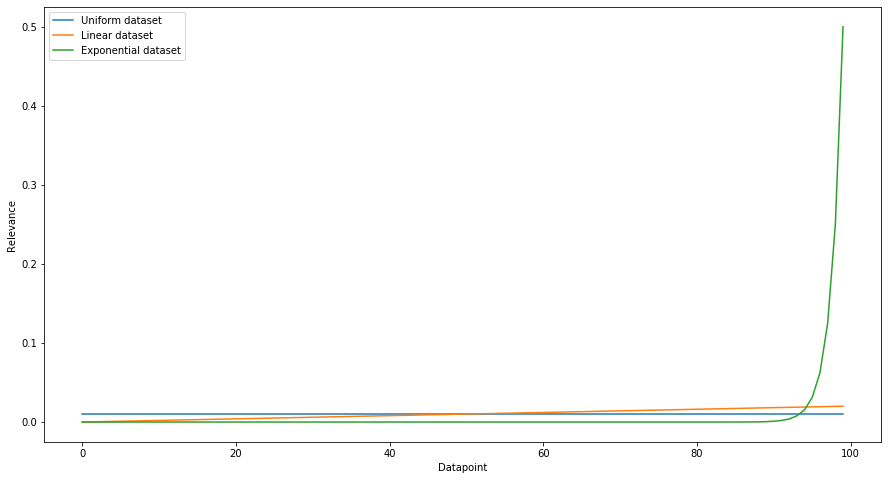

In [9]:
# Plot the relevance values of the synthetic dataset

x = np.arange(subjects_count)
plt.figure(figsize=(15,8))
plt.plot(x, uniform_dataset, label='Uniform dataset')
plt.plot(x, linear_dataset, label='Linear dataset')
plt.plot(x, exponential_dataset, label='Exponential dataset')

plt.ylabel('Relevance')
plt.xlabel('Datapoint')
plt.legend()
plt.show()

In [10]:
t = 100

# Generate the datapoints for a line in a graph
# query_func is either single_query or multi_query, which dictate how the dataset will be iterated over
# if single_query, the dataset will be repeated `iterations` number of times
# if multi_query, the columns in the dataset will be iterated over, repeating this process `iterations` times

def get_graph_line(query_func, iterations, dataset, k, p, theta):
    # needed due to a bug in tqdm for pretty printing
    print(' ', end='', flush=True)

    label = 'ndcg@{:d}>={:.2f}'.format(k, theta)
    
    datapoints = query_func(dataset, t, k, p, theta, iterations)
    return label, datapoints

In [11]:
def save_graph_data(datapoint_map, file_name):
    df = pd.DataFrame(datapoint_map)
    df['x'] = df.index + 1
    df.to_csv(file_name, index=False)

In [12]:
markevery_cycle = [
    0.05,
    0.07,
    0.11,
    0.13,
    0.17,
    0.19,
]


# plot a graph, making sure that the lines can be read and interpretted
# (unlike in the original paper)

def plot_graph(datapoint_map, title):
    plt.figure(figsize=(15,8))
        
    for (label, datapoints), markevery in zip(datapoint_map.items(), markevery_cycle):
        plt.plot(datapoints, label=label, marker='o', markersize=5.0, markevery=markevery)

    plt.title(title)
    plt.xlabel('Iterations')
    plt.ylabel('Unfairness')
    plt.legend()

    plt.show()

In [13]:
# we only have 2 experiments: when k = 1 and p = 1.0, and when k = 5, p = 0.5
# this reducec the number of arguments we have to pass around

def get_p(k):
    if k == 1:
        # this isn't really needed, as in the end it would get normalised, either way
        p = 1.0
    else:
        p = 0.5
        
    return p


# since the query_function is abstracted-away,
# we'd need a way to compute the corresponding relevance and objective lines (from the graphs)

def relevance_func(query_func):
    if query_func == single_query:
        return single_query_relevance
    if query_func == multi_query:
        return multi_query_relevance
    
    assert False, 'Unknown function'


def objective_func(query_func):
    if query_func == single_query:
        return single_query_objective
    if query_func == multi_query:
        return multi_query_objective
    
    assert False, 'Unknown function'

In [14]:
# NOTE: if you are unable to run the experiments below, try disabling the parallelism through this flag
# issues with parallelism were observed on Windows machines

parallel = True

# basically, call the query func with the given parameters, for each `theta` in `thetas`
# add in the relevance and objective graph lines
# save the results on disk and plot a graph

def do_experiment_plot_graph(query_func, iterations, dataset, thetas, k, file_name, title):        
    p = get_p(k)
        
    if parallel is True:
        freeze_support()
        with Pool(processes=None, initializer=tqdm.set_lock, initargs=(tqdm.get_lock(),)) as pool:
            datapoint_map = dict(tqdm(
                pool.imap(functools.partial(get_graph_line, query_func, iterations, dataset, k, p), thetas),
                total=len(thetas)
            ))
    else:
        datapoint_map = {}

        for theta in tqdm(thetas):
            label, datapoints = get_graph_line(query_func, iterations, dataset, k, p, theta)
            datapoint_map[label] = datapoints
            

    datapoint_map['relevance'] = relevance_func(query_func)(dataset, k, p, iterations)
    datapoint_map['objective'] = objective_func(query_func)(dataset, k, p, iterations)
    
    save_graph_data(datapoint_map, file_name)
    plot_graph(datapoint_map, title)

## Synthetic dataset

In [15]:
# Set parameters for the synthetic dataset

iterations = 300
thetas = [0.0, 0.6, 0.8, 1.0]

### Singular attention

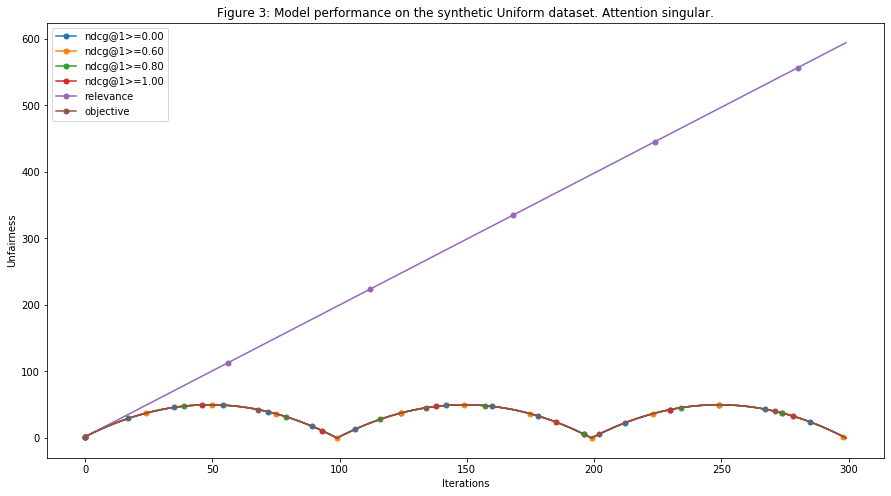

In [16]:
# repeatedly rank the uniform_dataset
# and draw a plot with how the unfairness progresses under different constraints

do_experiment_plot_graph(single_query, iterations=iterations, dataset=uniform_dataset, thetas=thetas, k=1,
                         file_name='graph_data/uniform_dataset_singular_attention.csv',
                         title='Figure 3: Model performance on the synthetic Uniform dataset. Attention singular.')

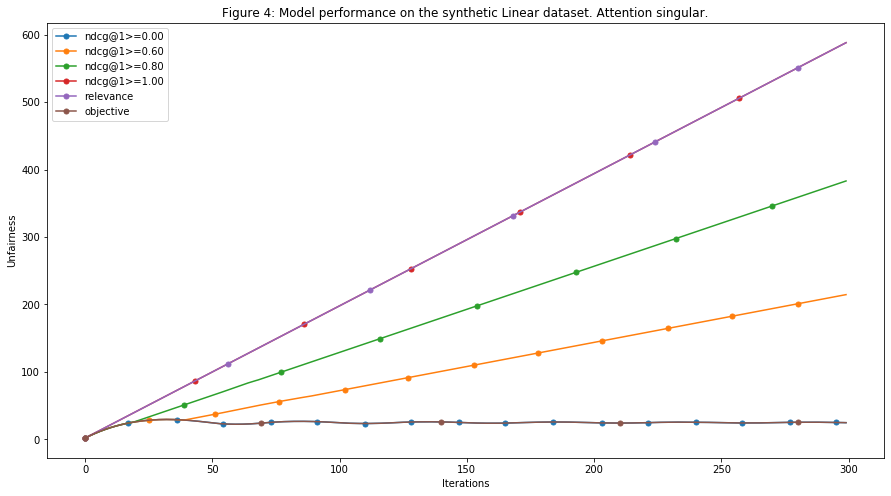

In [17]:
do_experiment_plot_graph(single_query, iterations=iterations, dataset=linear_dataset, thetas=thetas, k=1,
                         file_name='graph_data/linear_dataset_singular_attention.csv',
                         title='Figure 4: Model performance on the synthetic Linear dataset. Attention singular.')

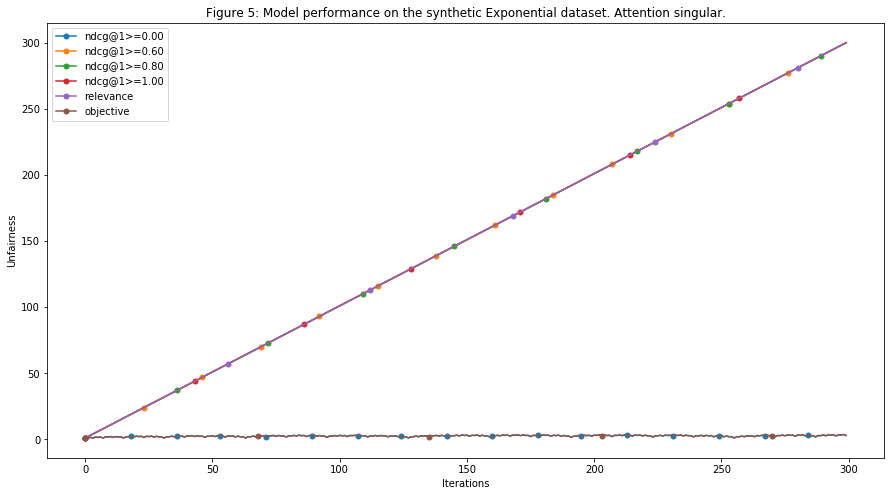

In [18]:
do_experiment_plot_graph(single_query, iterations=iterations, dataset=exponential_dataset, thetas=thetas, k=1,
                         file_name='graph_data/exponential_dataset_singular_attention.csv',
                         title='Figure 5: Model performance on the synthetic Exponential dataset. Attention singular.')

### Geometric attention

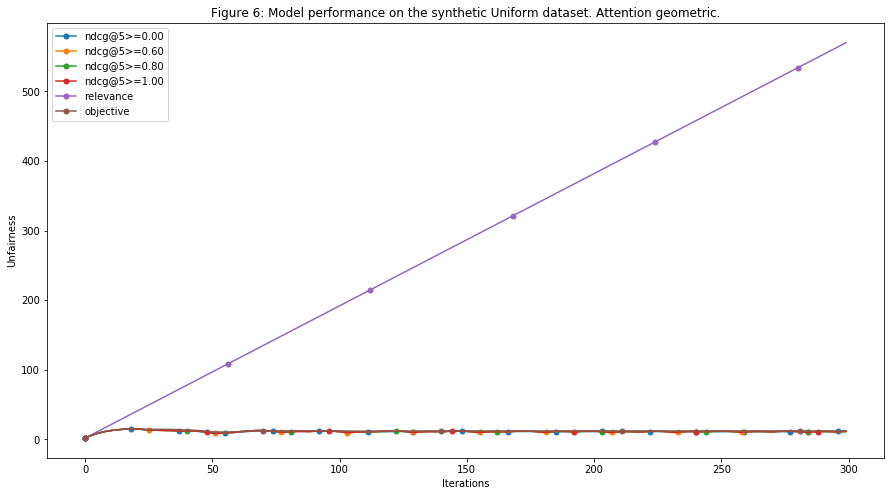

In [19]:
do_experiment_plot_graph(single_query, iterations=iterations, dataset=uniform_dataset, thetas=thetas, k=5,
                         file_name='graph_data/uniform_dataset_geometric_attention.csv',
                         title='Figure 6: Model performance on the synthetic Uniform dataset. Attention geometric.')

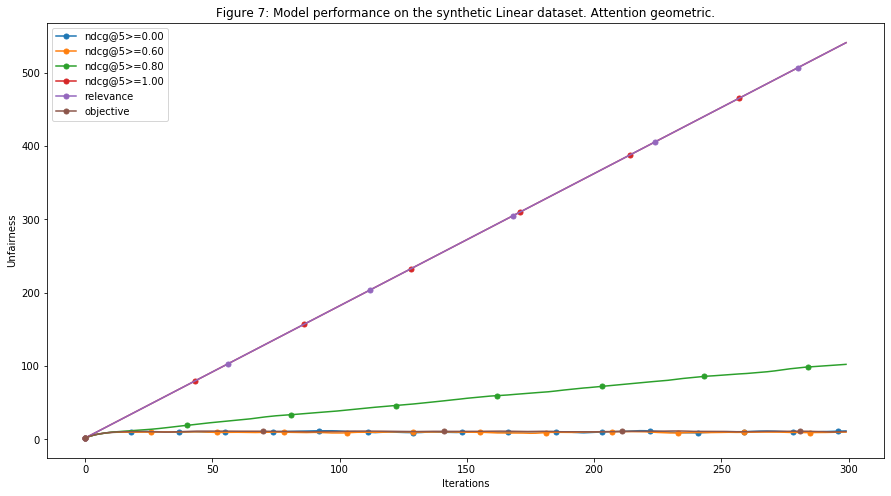

In [20]:
do_experiment_plot_graph(single_query, iterations=iterations, dataset=linear_dataset, thetas=thetas, k=5,
                         file_name='graph_data/linear_dataset_geometric_attention.csv',
                         title='Figure 7: Model performance on the synthetic Linear dataset. Attention geometric.')

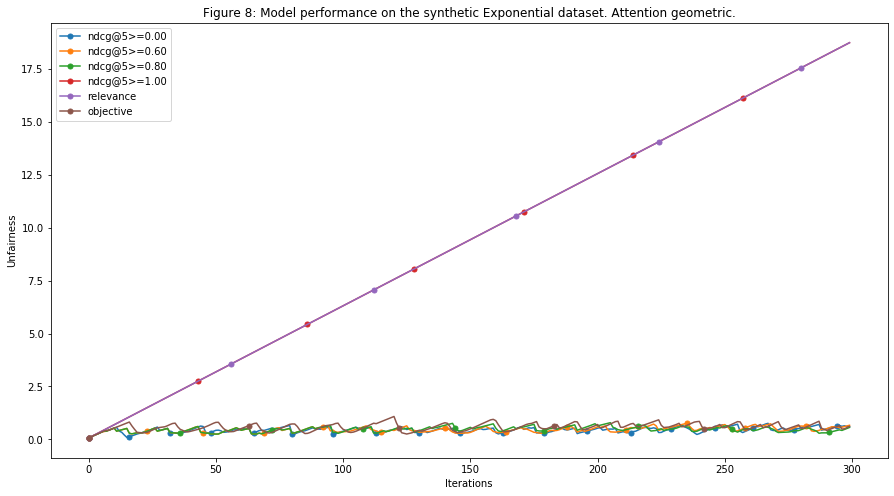

In [21]:
do_experiment_plot_graph(single_query, iterations=iterations, dataset=exponential_dataset, thetas=thetas, k=5,
                         file_name='graph_data/exponential_dataset_geometric_attention.csv',
                         title='Figure 8: Model performance on the synthetic Exponential dataset. Attention geometric.')

## AirBnB dataset

In [22]:
# we are only interested in these rankings

query_columns = [
    'review_scores_rating',
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value',
]

# read the dataset, and normalise the relevances to sum to 1.0

def read_dataset(fn):
    dataset = pd.read_csv('AirBnB-Data/{:s}.csv'.format(fn))
    
    for column in query_columns:
        dataset[column] = normalise_dataset(dataset[column])

    return dataset

In [23]:
# read the whole AirBnB dataset

boston_dataset = read_dataset('boston')
geneva_dataset = read_dataset('geneva')
hong_kong_dataset = read_dataset('hongkong')

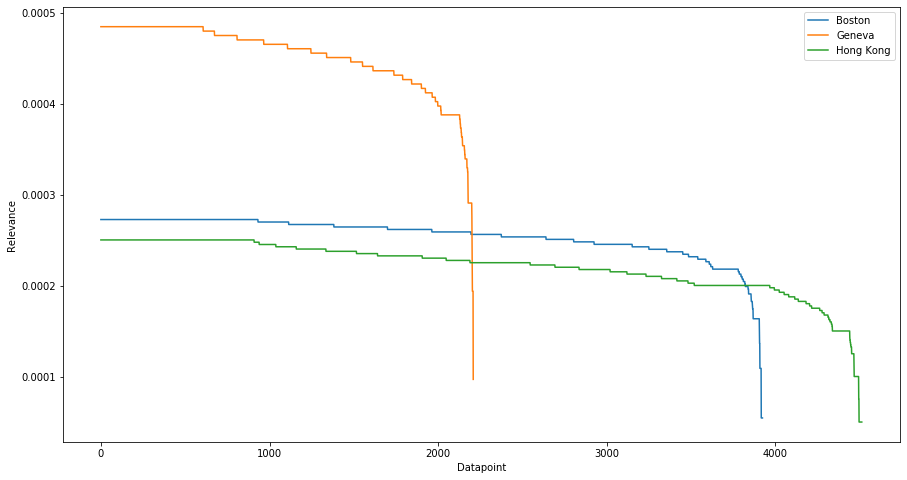

In [24]:
# plot how the relevances of the AirBnB dataset look like
# as they are normalised, the values depend on their sizes
# it can be observed that most ratings are high

plt.figure(figsize=(15, 8))

plt.plot(np.sort(boston_dataset['review_scores_rating'])[::-1], label='Boston')
plt.plot(np.sort(geneva_dataset['review_scores_rating'])[::-1], label='Geneva')
plt.plot(np.sort(hong_kong_dataset['review_scores_rating'])[::-1], label='Hong Kong')

plt.ylabel('Relevance')
plt.xlabel('Datapoint')
plt.legend()
plt.show()

### Single-query

In [25]:
# Set parameters for the AirBnB single-qeury dataset

iterations=20000

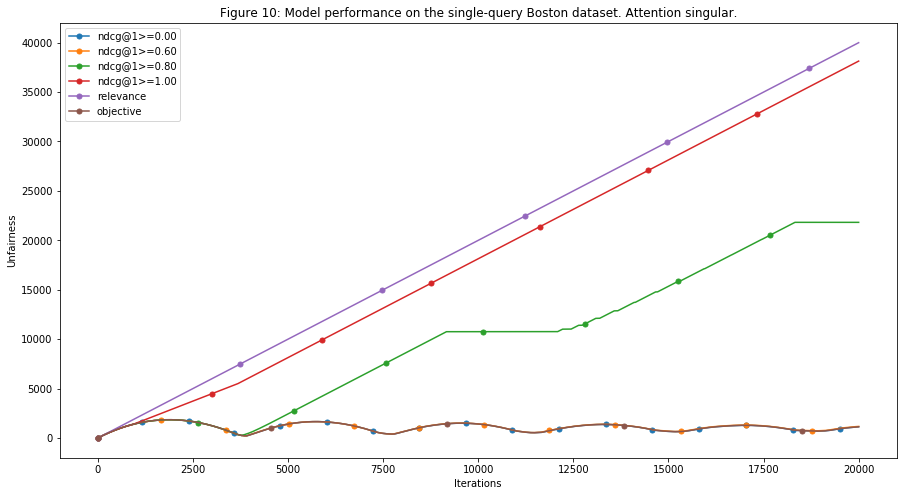

In [26]:
# repeatedly rank the Boston dataset, using only the review_scores_rating ranking
# and draw a plot with how the unfairness progresses under different constraints

do_experiment_plot_graph(single_query, iterations=iterations, dataset=boston_dataset['review_scores_rating'],
                         thetas=thetas, k=1,
                         file_name='graph_data/boston_dataset_single_query.csv',
                         title='Figure 10: Model performance on the single-query Boston dataset. Attention singular.')

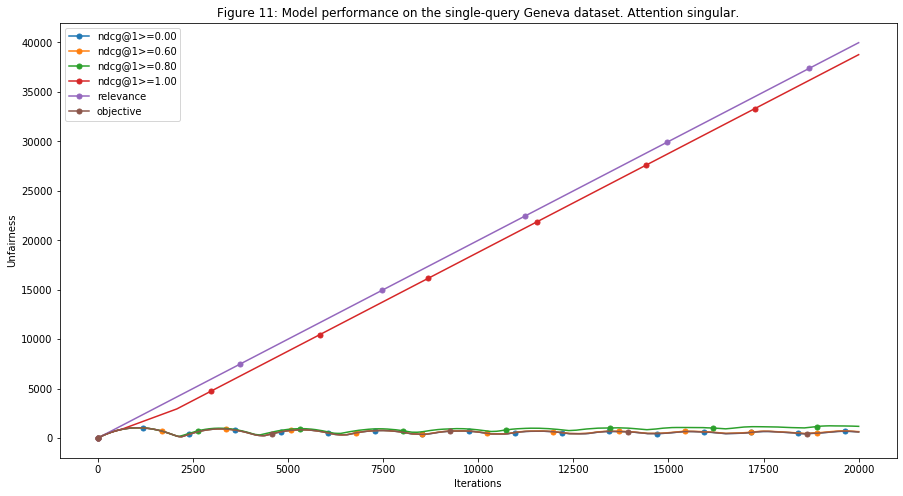

In [27]:
do_experiment_plot_graph(single_query, iterations=iterations, dataset=geneva_dataset['review_scores_rating'],
                         thetas=thetas, k=1,
                         file_name='graph_data/geneva_dataset_single_query.csv',
                         title='Figure 11: Model performance on the single-query Geneva dataset. Attention singular.')

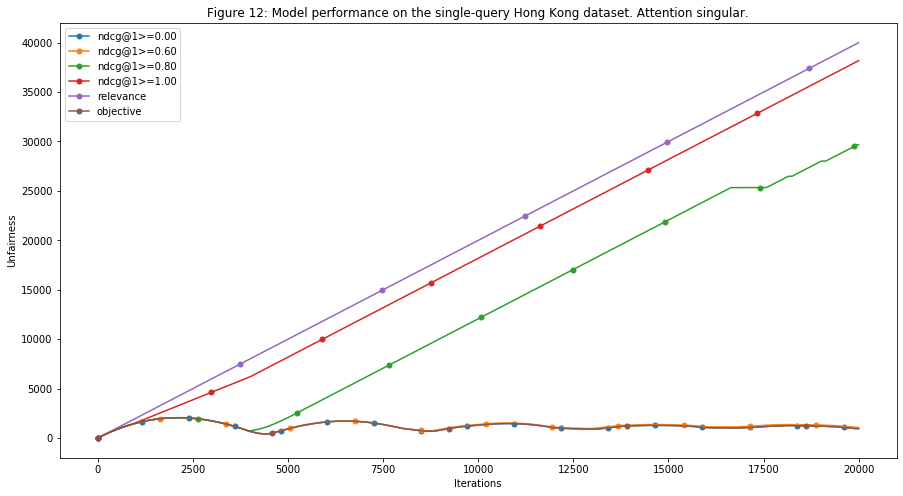

In [28]:
do_experiment_plot_graph(single_query, iterations=iterations, dataset=hong_kong_dataset['review_scores_rating'],
                         thetas=thetas, k=1,
                         file_name='graph_data/hong_kong_dataset_single_query.csv',
                         title='Figure 12: Model performance on the single-query Hong Kong dataset. Attention singular.')

### Multi-query

In [29]:
# select only the features we are interested in

def multi_query_features(dataset):
    return [dataset[column].to_numpy() for column in query_columns]        

In [30]:
# Set parameters for the AirBnB multi-qeury dataset

iterations=3000

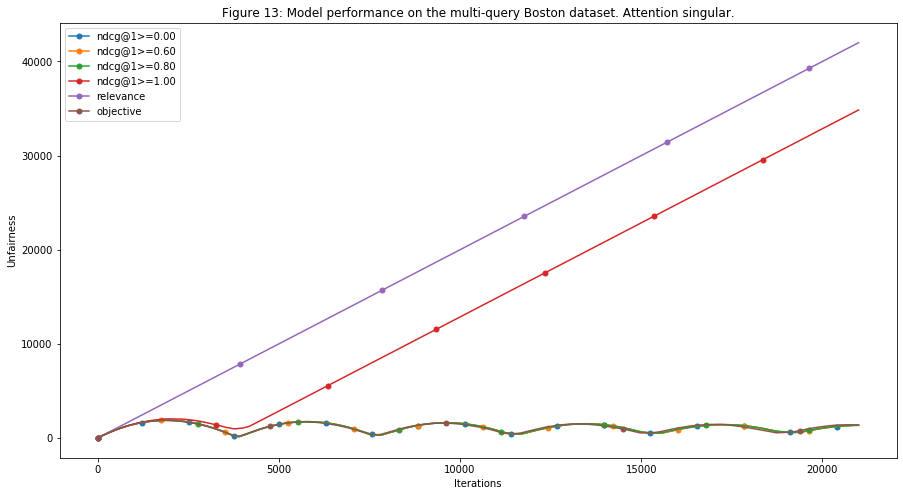

In [31]:
# repeatedly rank the Boston dataset, but this time use all 7 metrics of the entire dataset
# and draw a plot with how the unfairness progresses under different constraints

do_experiment_plot_graph(multi_query, iterations=iterations, dataset=multi_query_features(boston_dataset),
                         thetas=thetas, k=1,
                         file_name='graph_data/boston_dataset_multi_query.csv',
                         title='Figure 13: Model performance on the multi-query Boston dataset. Attention singular.')

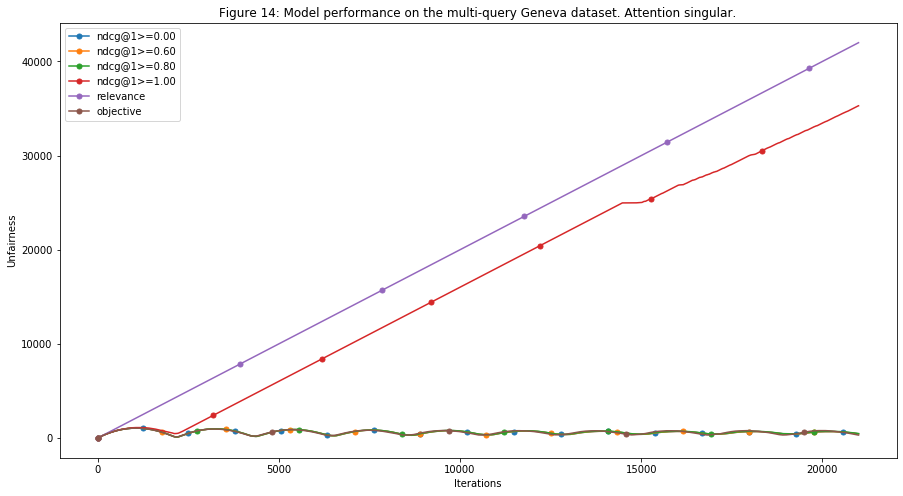

In [32]:
do_experiment_plot_graph(multi_query, iterations=iterations, dataset=multi_query_features(geneva_dataset),
                         thetas=thetas, k=1,
                         file_name='graph_data/geneva_dataset_multi_query.csv',
                         title='Figure 14: Model performance on the multi-query Geneva dataset. Attention singular.')

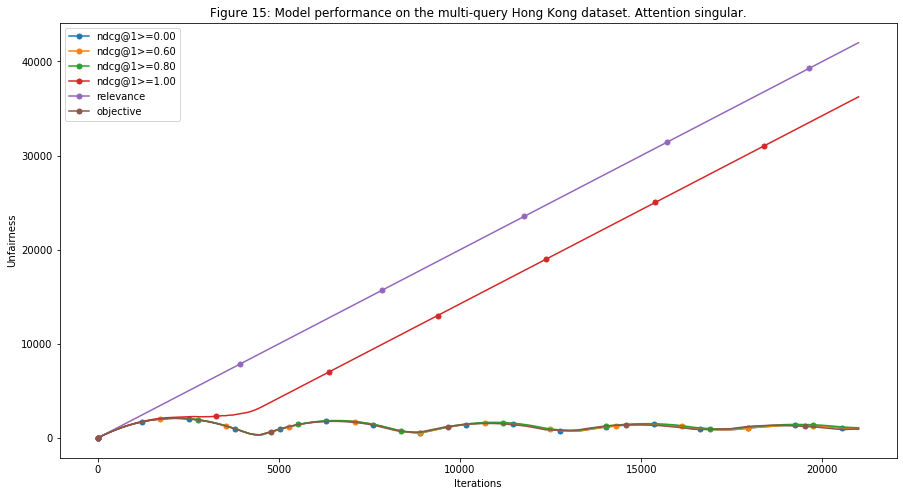

In [33]:
do_experiment_plot_graph(multi_query, iterations=iterations, dataset=multi_query_features(hong_kong_dataset),
                         thetas=thetas, k=1,
                         file_name='graph_data/hong_kong_dataset_multi_query.csv',
                         title='Figure 15: Model performance on the multi-query Hong Kong dataset. Attention singular.')

## Vary the prefilter count

In [34]:
boston_dataset_size = len(boston_dataset['review_scores_rating'])
linear_dataset_size = len(linear_dataset)

print('Boston dataset:', boston_dataset_size,
      'prefilter percentage: {:.2f}'.format(t/boston_dataset_size*100))
print('Linear dataset:', linear_dataset_size,
      'prefilter percentage: {:.2f}'.format(t/linear_dataset_size*100))

Boston dataset: 3924 prefilter percentage: 2.55
Linear dataset: 100 prefilter percentage: 100.00


We try and see how the linear dataset's unfairness would perform with the same prefilter portion

In [35]:
iterations = 300
t = int(math.ceil(linear_dataset_size*t/boston_dataset_size))
print('Using a prefilter value of:', t)

Using a prefilter value of: 3


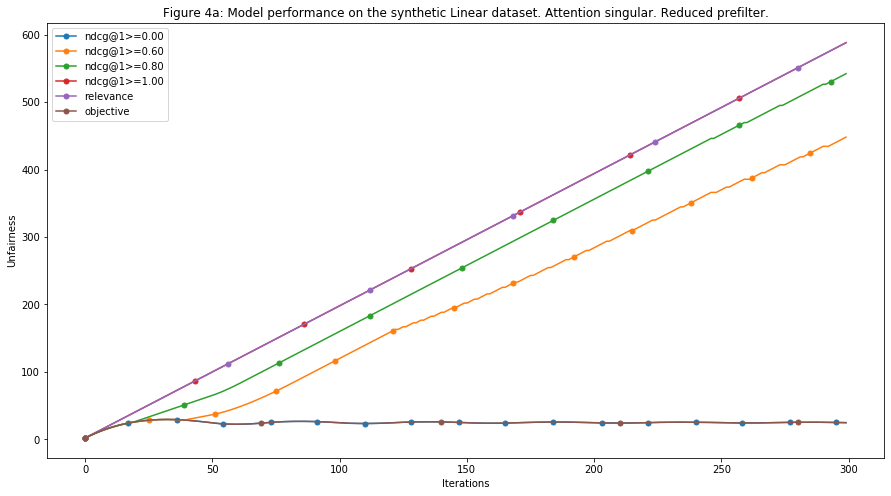

In [36]:
do_experiment_plot_graph(single_query, iterations=iterations, dataset=linear_dataset, thetas=thetas, k=1,
                         file_name='graph_data/linear_dataset_singular_attention_prefilter.csv',
                         title='Figure 4a: Model performance on the synthetic Linear dataset. Attention singular. Reduced prefilter.')

# End